# Introduction and Setup

This notebook utilizes a CycleGAN architecture to add Monet-style to photos. For this tutorial, we will be using the TFRecord dataset. Import the following packages and change the accelerator to TPU.

For more information, check out [TensorFlow](https://www.tensorflow.org/tutorials/generative/cyclegan) and [Keras](https://keras.io/examples/generative/cyclegan/) CycleGAN documentation pages.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import linalg

%matplotlib inline

import os, re

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [2]:
IMAGE_SIZE = [256, 256]
EPOCHS = 26
BATCH_SIZE = 4

GCS_PATH = KaggleDatasets().get_gcs_path()

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

Define the function to extract the image from the files.

In [4]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:
def get_gan_dataset(files, augment=None, repeat=True, shuffle=True, batch_size=1):

    ds = load_dataset(files) # Load the Monet images
    
    # If an augment function is passed, apply the augmentation to the images 
    if augment:
        ds = ds.map(lambda p: augment(p, True), num_parallel_calls=AUTOTUNE)
        
    #If repeat is set to True, apply to the images
    if repeat:
        ds = ds.repeat()
        
    #If shuffle is set to True, apply to the images
    if shuffle:
        ds = ds.shuffle(2048)
    
    # After the data has been augmented, repeated, and shuffled, then
    # apply the batch size of 4
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
        
    return ds


def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)

def data_augment(image, real=False):
    
    # Randomly decide to rotate the image
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    # Randomly decide to flip the image
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    # Randomly decide to crop the image
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, 3])
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
    
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
            
    if real:
        blur = _gaussian_kernel(3, 2, 3, image.dtype)
        image = tf.nn.depthwise_conv2d(image[None], blur, [1,1,1,1], 'SAME')
        image = tf.reshape(image, [256, 256, 3])
    
    return image

def photo_blur(image):

    blur = _gaussian_kernel(3, 2, 3, image.dtype)
    image = tf.nn.depthwise_conv2d(image[None], blur, [1,1,1,1], 'SAME')
    image = tf.reshape(image, [256, 256, 3])
    
    return image

Let's load in our datasets.

In [6]:
monet_ds = get_gan_dataset(MONET_FILENAMES, augment=data_augment, repeat=False, shuffle=True, batch_size=BATCH_SIZE)
photo_ds = get_gan_dataset(PHOTO_FILENAMES, augment=data_augment, repeat=False, shuffle=True, batch_size=BATCH_SIZE)

full_dataset = tf.data.Dataset.zip((monet_ds.repeat(), photo_ds.repeat()))

In [7]:
example_monet , example_photo = next(iter(full_dataset))

Let's  visualize a photo example and a Monet example.

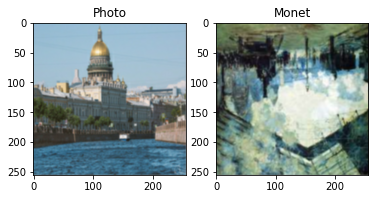

In [8]:
sns.reset_orig()

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, shape, apply_instancenorm=True):
    initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        
    inputs = keras.Input(shape=shape[1:])

    x = layers.Conv2D(filters, size, strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             use_bias=False)(inputs)   
    
    if apply_instancenorm:
        x = tfa.layers.InstanceNormalization(gamma_initializer=initializer)(x)

    x = layers.LeakyReLU()(x)
        
    model = keras.Model(inputs=inputs, outputs=x)

    return model

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [10]:
def upsample(filters, size, shape, apply_dropout=False):
    initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inputs = keras.Input(shape=shape[1:])

    x = layers.Conv2DTranspose(filters, size, strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                use_bias=False)(inputs)

    x = tfa.layers.InstanceNormalization(gamma_initializer=initializer)(x)
    
    if apply_dropout:
        x = layers.Dropout(0.5)(x)
        
    x = layers.ReLU()(x)
    model = keras.Model(inputs=inputs, outputs=x)

    return model

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [11]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    down_stack = [{"filters":64,"size":4,"instancenorm":False},
                       {"filters":128,"size":4,"instancenorm":True},
                       {"filters":256,"size":4,"instancenorm":True},
                       {"filters":512,"size":4,"instancenorm":True},
                       {"filters":512,"size":4,"instancenorm":True},
                       {"filters":512,"size":4,"instancenorm":True},
                       {"filters":512,"size":4,"instancenorm":True},
                       {"filters":512,"size":4,"instancenorm":True}]


    
    up_stack = [{"filters":512,"size":4,"dropout":True},
               {"filters":512,"size":4,"dropout":True},
               {"filters":512,"size":4,"dropout":True},
               {"filters":512,"size":4,"dropout":False},
               {"filters":256,"size":4,"dropout":False},
               {"filters":128,"size":4,"dropout":False},
               {"filters":64,"size":4,"dropout":False}]

    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  activation='tanh',
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer) # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for obj in down_stack:
        x = downsample(obj['filters'],obj['size'],x.shape,obj['instancenorm'])(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for obj, skip in zip(up_stack, skips):
        x = upsample(obj['filters'],obj['size'],x.shape,obj['dropout'])(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [12]:
def Discriminator():
    inputs = layers.Input(shape=[256,256,3], name='input_image')
    initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    x = inputs

    downsample_stack = [{"filters":64,"size":4, 'instancenorm':False},
                       {"filters":128,"size":4, 'instancenorm':True},
                       {"filters":256,"size":4, 'instancenorm':True}]

    for obj in downsample_stack:
        x = downsample(obj['filters'],obj['size'],x.shape,obj['instancenorm'])(x)

    zero_pad1 = layers.ZeroPadding2D()(x) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm = tfa.layers.InstanceNormalization(gamma_initializer=initializer)(conv)

    leaky_relu = layers.LeakyReLU()(norm)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inputs, outputs=last)

In [13]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

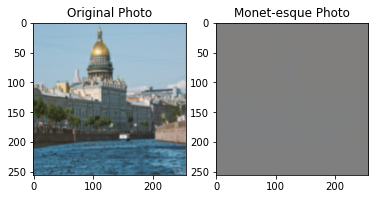

In [14]:
sns.reset_orig()

to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [15]:
with strategy.scope():
    cycle_model = tf.keras.applications.MobileNet(input_shape=(256,256,3),pooling="avg",include_top=False)
    cycle_model.trainable = False
    
with strategy.scope():
    inception_model = tf.keras.applications.InceptionV3(input_shape=(256,256,3),pooling="avg",include_top=False)
    inception_model.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [16]:
def calculate_frechet_distance(mu_FID,sigma_FID,mu,sigma):
    fid_epsilon = 1e-14
    mu_FID = np.atleast_1d(mu_FID)
    mu = np.atleast_1d(mu)
    sigma_FID = np.atleast_2d(sigma_FID)
    sigma = np.atleast_2d(sigma)

    assert mu_FID.shape == mu.shape, 'Training and test mean vectors have different lengths'
    assert sigma_FID.shape == sigma.shape, 'Training and test covariances have different dimensions'

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma_FID.dot(sigma), disp=False)
    if not np.isfinite(covmean).all():
        msg = f'fid calculation produces singular product; adding {fid_epsilon} to diagonal of cov estimates'
        warnings.warn(msg)
        offset = np.eye(sigma_FID.shape[0]) * fid_epsilon
        covmean = linalg.sqrtm((sigma_FID + offset).dot(sigma + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError(f'Imaginary component {m}')
        covmean = covmean.real
    tr_covmean = np.trace(covmean)
    return (mu_FID - mu).dot(mu_FID - mu) + np.trace(sigma_FID) + np.trace(sigma) - 2 * tr_covmean

def calculate_activation_statistics(images,fid_model):
        act=fid_model.predict(images)
        mu = np.mean(act, axis=0)
        sigma = np.cov(act, rowvar=False)
        return mu, sigma
    
mu, sigma = calculate_activation_statistics(monet_ds,inception_model)

def FID(images,gen_model,inception_model=inception_model,mu=mu, sigma=sigma):
    with strategy.scope():
        inp = layers.Input(shape=[256, 256, 3], name='input_image')
        x = gen_model(inp)
        x = inception_model(x)
        fid_model = tf.keras.Model(inputs=inp, outputs=x)

    mu_FID, sigma_FID = calculate_activation_statistics(images,fid_model)

    fid_value = calculate_frechet_distance(mu_FID, sigma_FID, mu, sigma)

    return fid_value

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
            "cycle_loss": total_cycle_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [18]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [19]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [20]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.keras.losses.Huber(0.5,reduction=tf.keras.losses.Reduction.NONE)(cycle_model(real_image), cycle_model(cycled_image)))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [21]:
with strategy.scope():
    def identity_loss(real_image, translated_image, LAMBDA):
        loss = tf.reduce_mean(tf.keras.losses.Huber(0.5,reduction=tf.keras.losses.Reduction.NONE)(tf.nn.avg_pool2d(real_image, ksize=32, strides=16, padding="VALID"), tf.nn.avg_pool2d(translated_image, ksize=32, strides=16, padding="VALID")))
        return LAMBDA *  loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [22]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [24]:
fids=[]

monet_gen_losses = []
monet_disc_losses = []
photo_gen_losses = []
photo_disc_losses = []
cycle_losses = []

best_fid = np.inf
for epoch in range(1,EPOCHS+1):

    print("Epoch = ",epoch)    
    hist = cycle_gan_model.fit(
                full_dataset,
                epochs=1,
                steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
            ).history
    
    monet_gen_losses.append(np.array(hist['monet_gen_loss']).mean())
    monet_disc_losses.append(np.array(hist['monet_disc_loss']).mean())
    photo_gen_losses.append(np.array(hist['photo_gen_loss']).mean())
    photo_disc_losses.append(np.array(hist['photo_disc_loss']).mean())
    cycle_losses.append(np.array(hist['cycle_loss']).mean())

    cur_fid = FID(photo_ds,monet_generator,inception_model,mu,sigma)
    fids.append(cur_fid)

    print("Cur #{} FID = {}\n".format(epoch,cur_fid))

    best_fid = min(cur_fid, best_fid)
    print("Best FID: "+str(best_fid))
    
monet_generator.save('monet_generator_'+str(epoch)+'.h5')

Epoch =  1
1759/1759 [==============================] - 374s 143ms/step - monet_gen_loss: 1.9105 - photo_gen_loss: 2.0205 - monet_disc_loss: 0.6596 - photo_disc_loss: 0.6079 - cycle_loss: 1.0630
Cur #1 FID = 155.13729912848532

Best FID: 155.13729912848532
Epoch =  2
1759/1759 [==============================] - 249s 142ms/step - monet_gen_loss: 1.2405 - photo_gen_loss: 1.2591 - monet_disc_loss: 0.6646 - photo_disc_loss: 0.6615 - cycle_loss: 0.4022
Cur #2 FID = 150.679504373005

Best FID: 150.679504373005
Epoch =  3
1759/1759 [==============================] - 250s 142ms/step - monet_gen_loss: 1.1597 - photo_gen_loss: 1.1196 - monet_disc_loss: 0.6572 - photo_disc_loss: 0.6695 - cycle_loss: 0.2987
Cur #3 FID = 144.2384183284912

Best FID: 144.2384183284912
Epoch =  4
1759/1759 [==============================] - 250s 142ms/step - monet_gen_loss: 1.1640 - photo_gen_loss: 1.0942 - monet_disc_loss: 0.6466 - photo_disc_loss: 0.6659 - cycle_loss: 0.2741
Cur #4 FID = 142.0824750327738

Best FID

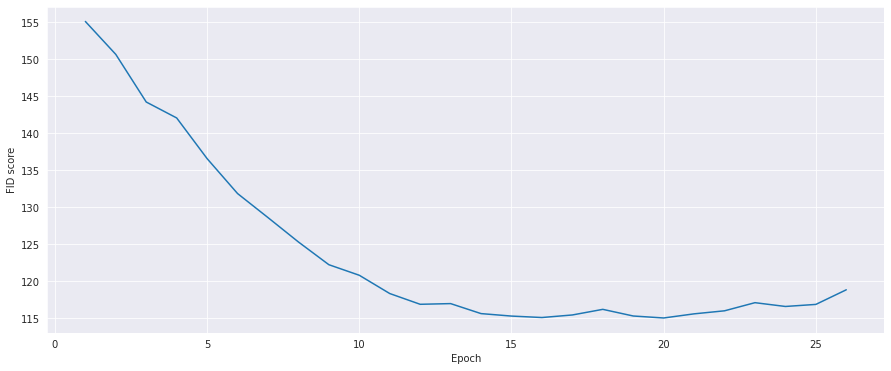

In [25]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(15, 6))

plt.plot(range(1, len(fids)+1), np.array(fids))
plt.xlabel("Epoch")
plt.ylabel("FID score")
plt.show()

Text(0.5, 1.0, '')

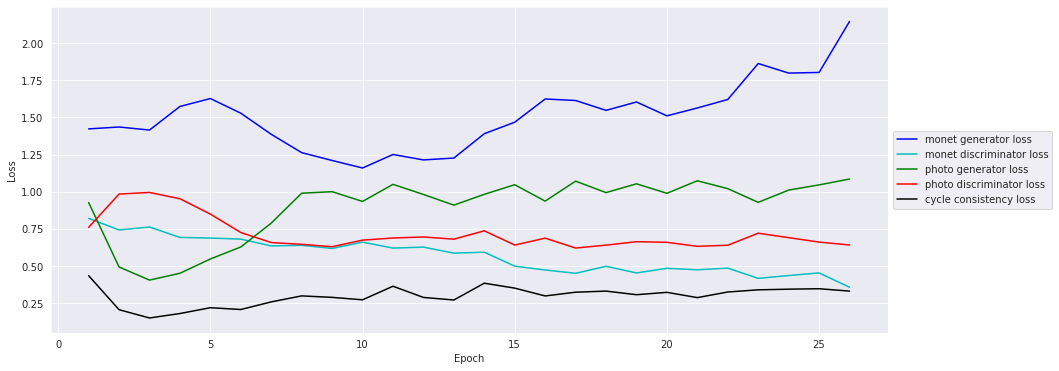

In [26]:
fig = plt.figure(figsize=(15, 6))

monet_loss_plt, = plt.plot(range(1, len(monet_gen_losses)+1), monet_gen_losses, 'b')
monet_disc_plt, = plt.plot(range(1,len(monet_disc_losses)+1), monet_disc_losses, 'c')
photo_loss_plt, = plt.plot(range(1,len(photo_gen_losses)+1), photo_gen_losses, 'g')
photo_disc_plt, = plt.plot(range(1,len(photo_disc_losses)+1), photo_disc_losses, 'r')
cycle_loss_plt, = plt.plot(range(1,len(cycle_losses)+1), cycle_losses, 'k')


plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend([monet_loss_plt, monet_disc_plt, photo_loss_plt, photo_disc_plt, cycle_loss_plt], 
          ['monet generator loss', 'monet discriminator loss', 'photo generator loss', 'photo discriminator loss', 'cycle consistency loss'],
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('')

# Visualize our Monet-esque photos

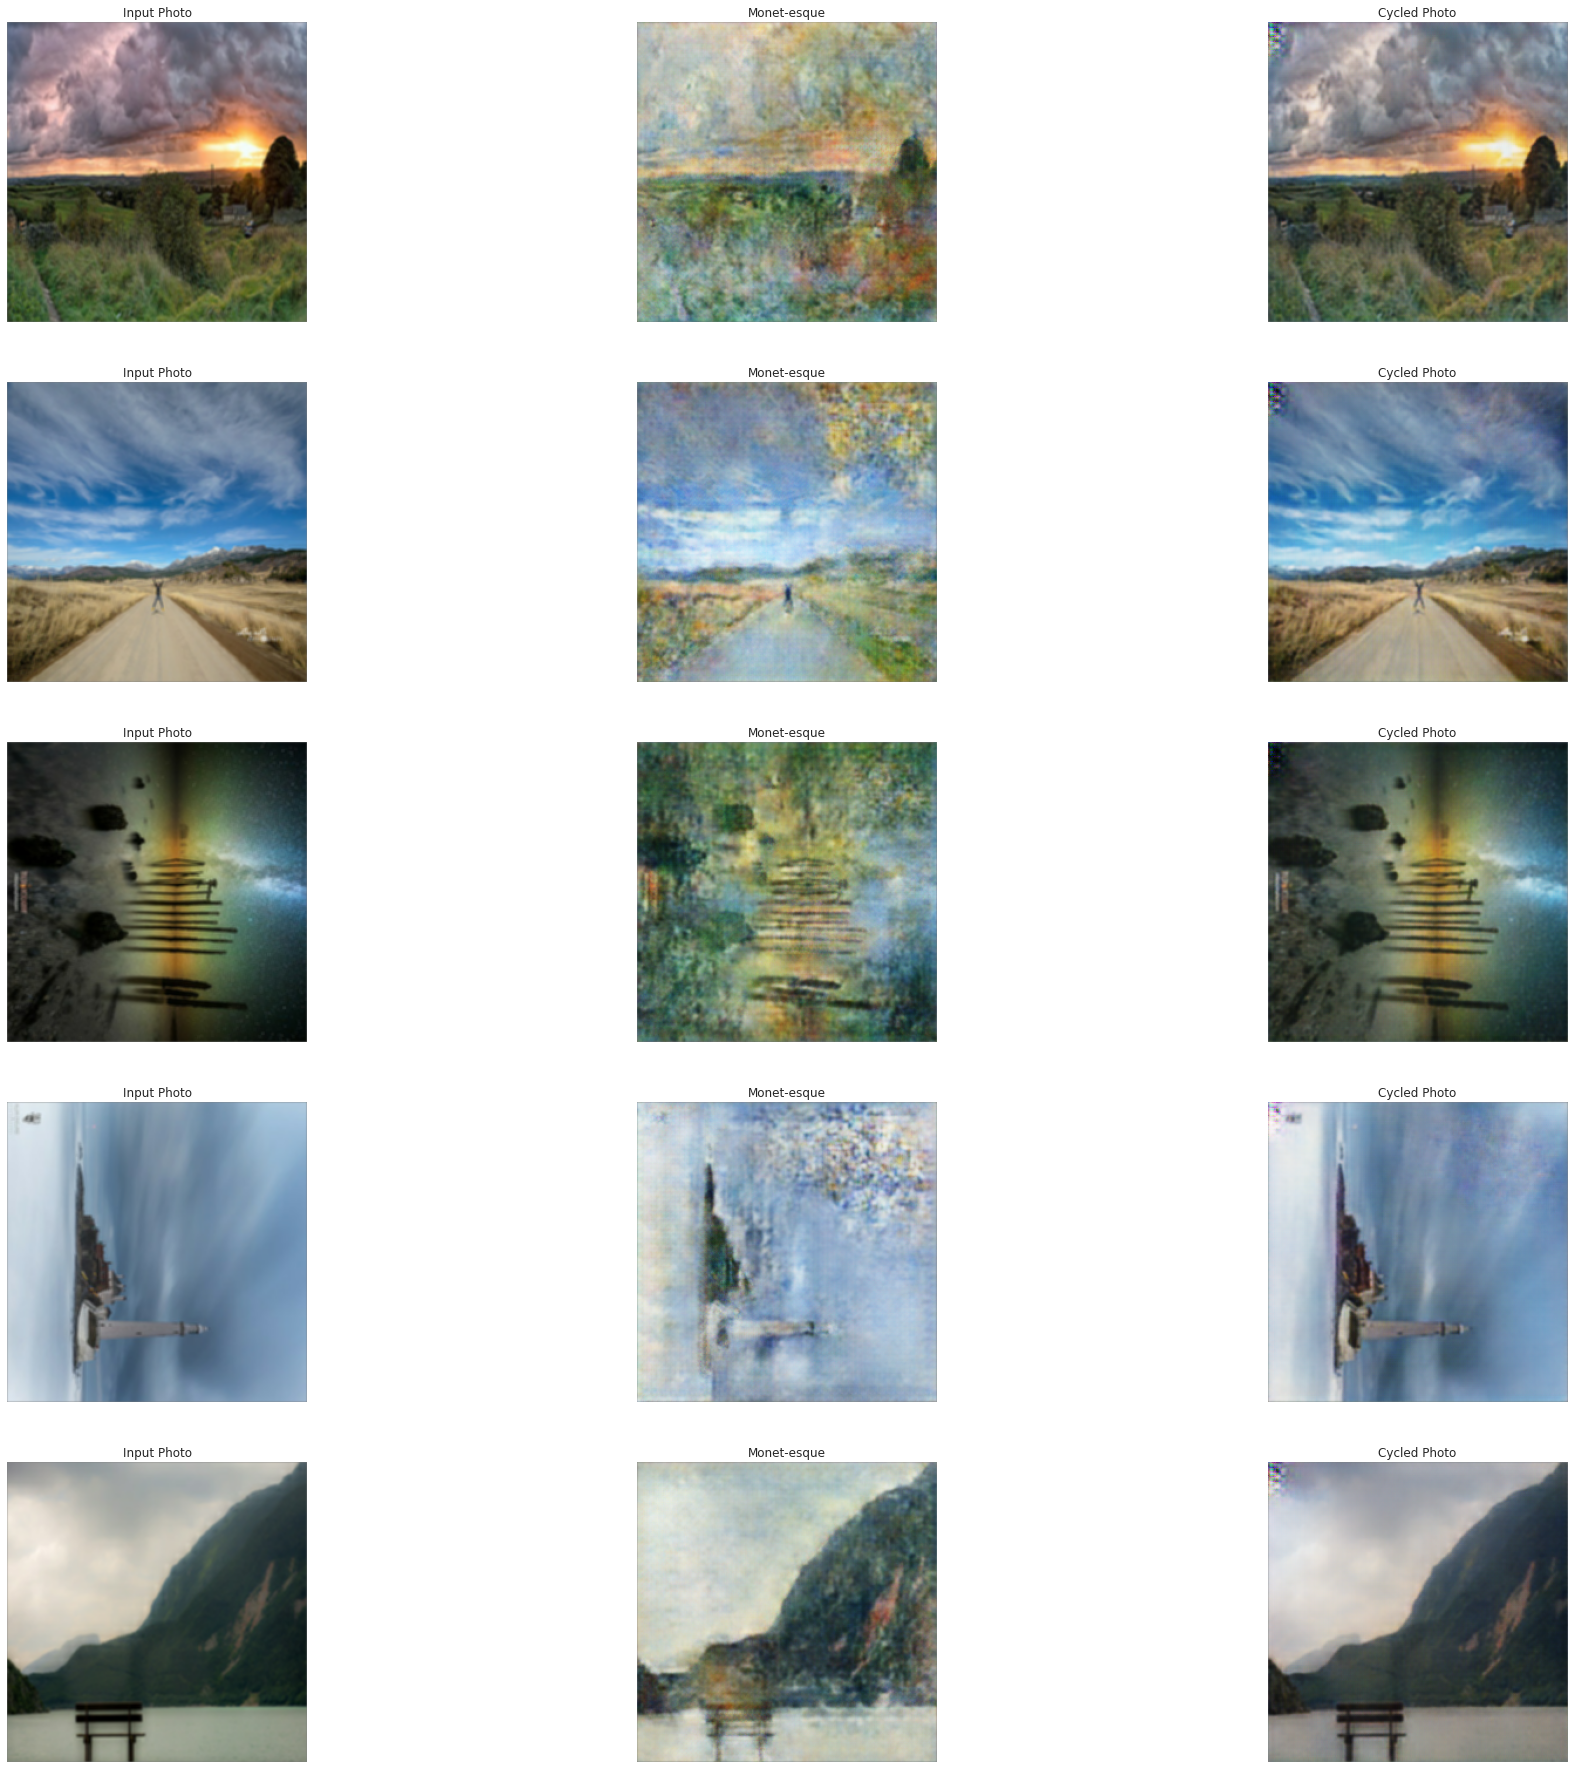

In [27]:
_, ax = plt.subplots(5, 3, figsize=(32, 32))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)
    cycledphoto = photo_generator(prediction, training=False)
    prediction = (prediction * 127.5 + 127.5)[0].numpy().astype(np.uint8)
    cycledphoto = (cycledphoto * 127.5 + 127.5)[0].numpy().astype(np.uint8)

    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(cycledphoto)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 2].set_title("Cycled Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

plt.show()

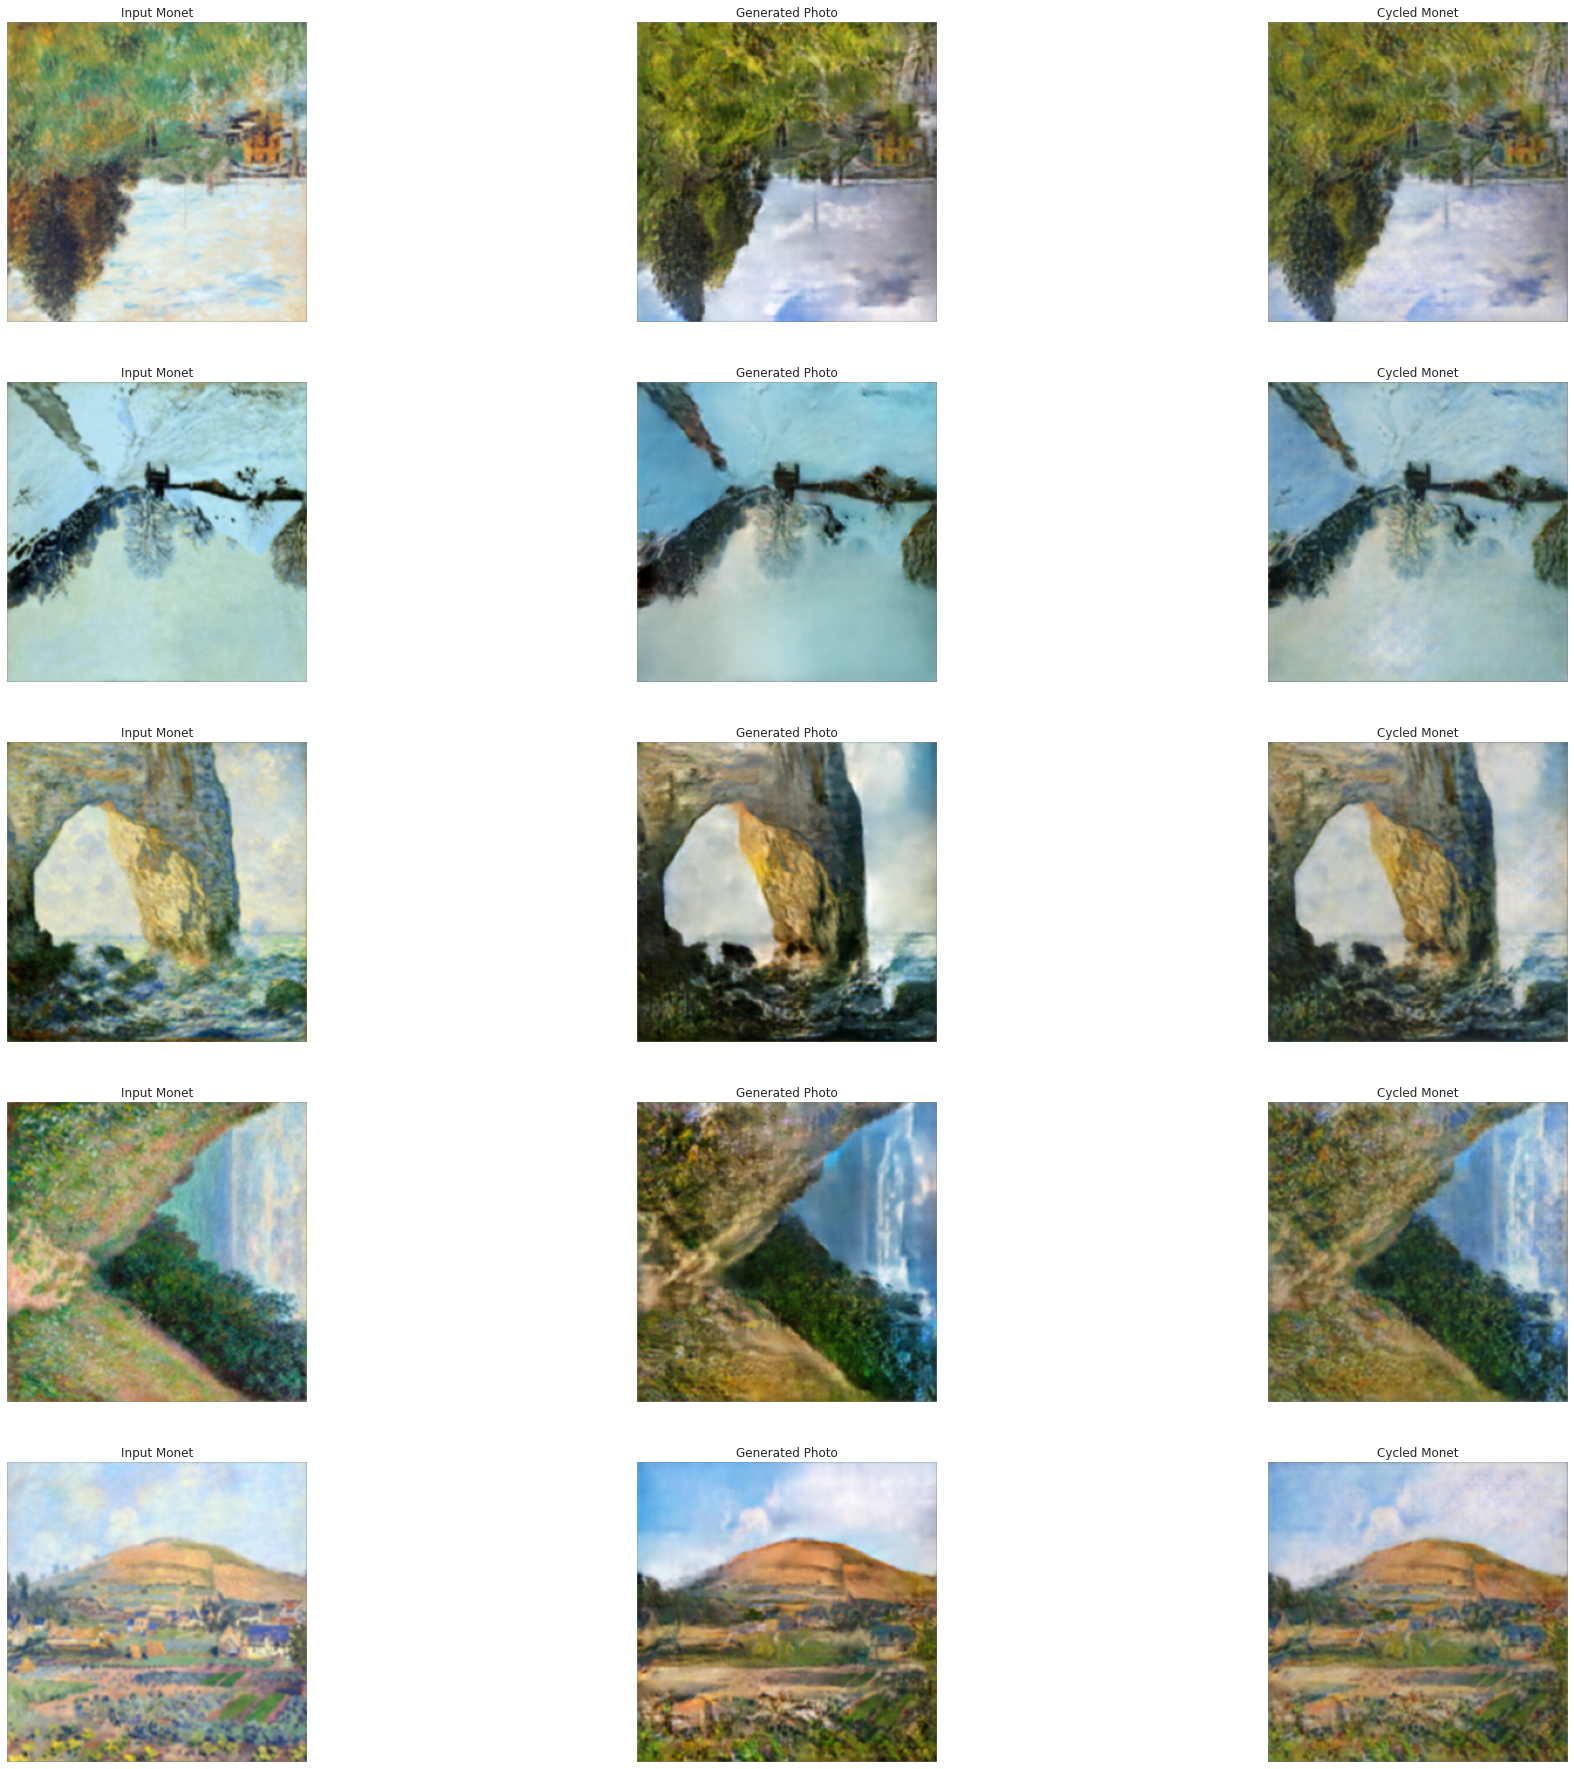

In [28]:
_, ax = plt.subplots(5, 3, figsize=(32, 32))
for i, img in enumerate(monet_ds.take(5)):
    prediction = photo_generator(img, training=False)
    cycledphoto = monet_generator(prediction, training=False)
    prediction = (prediction * 127.5 + 127.5)[0].numpy().astype(np.uint8)
    cycledphoto = (cycledphoto * 127.5 + 127.5)[0].numpy().astype(np.uint8)

    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(cycledphoto)
    ax[i, 0].set_title("Input Monet")
    ax[i, 1].set_title("Generated Photo")
    ax[i, 2].set_title("Cycled Monet")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

plt.show()

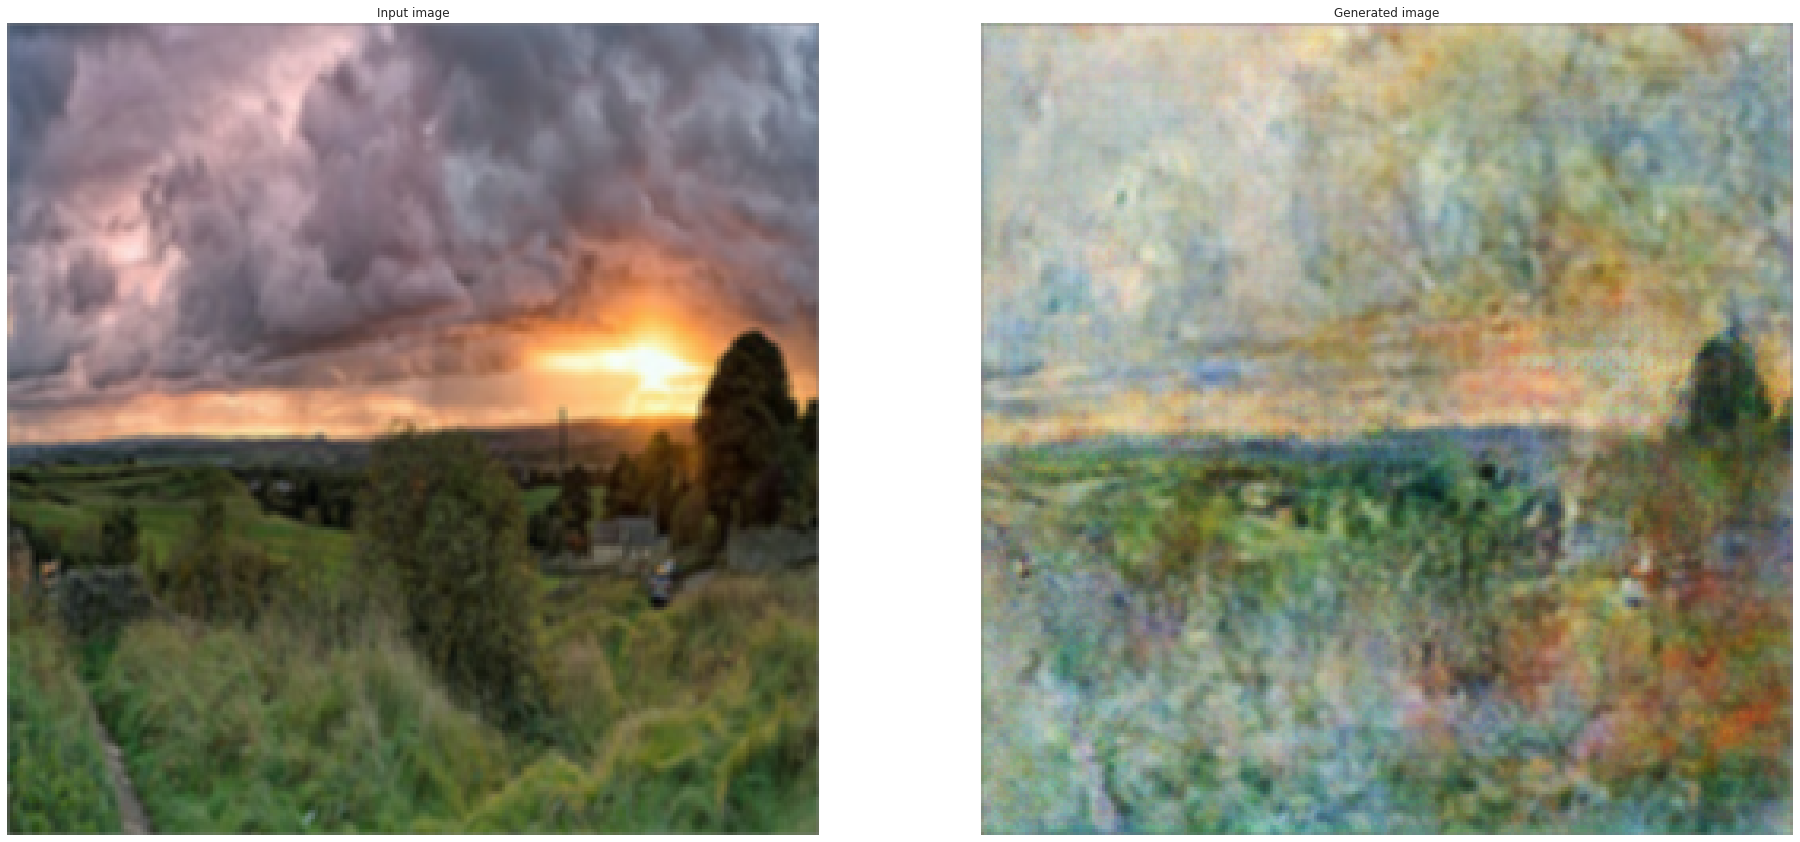

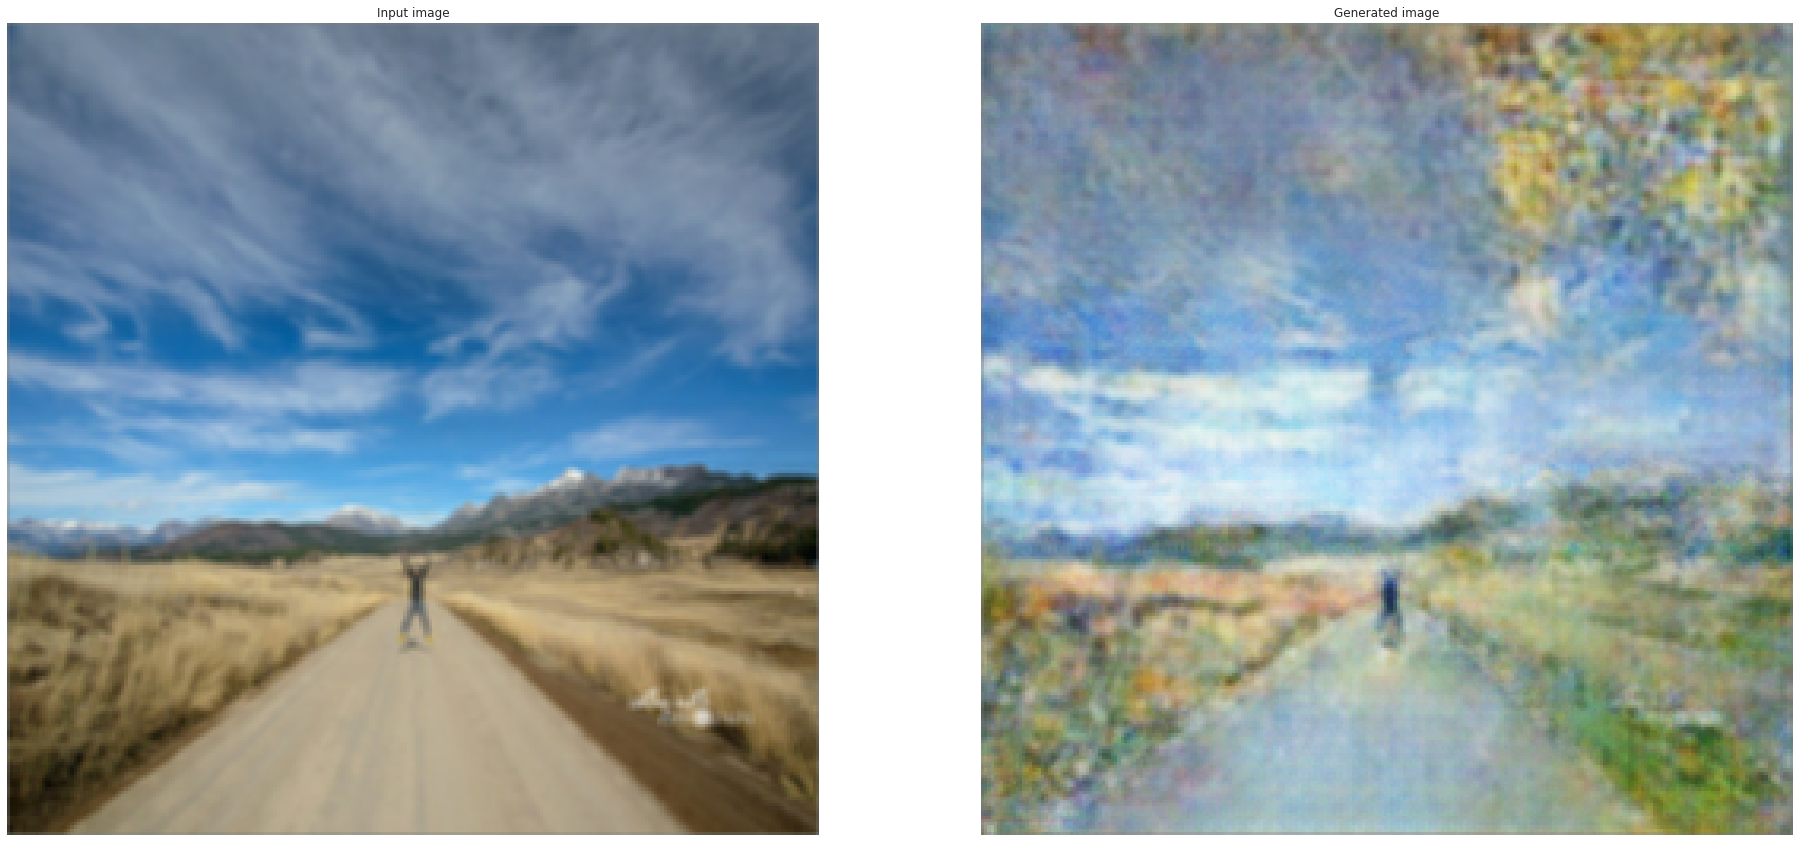

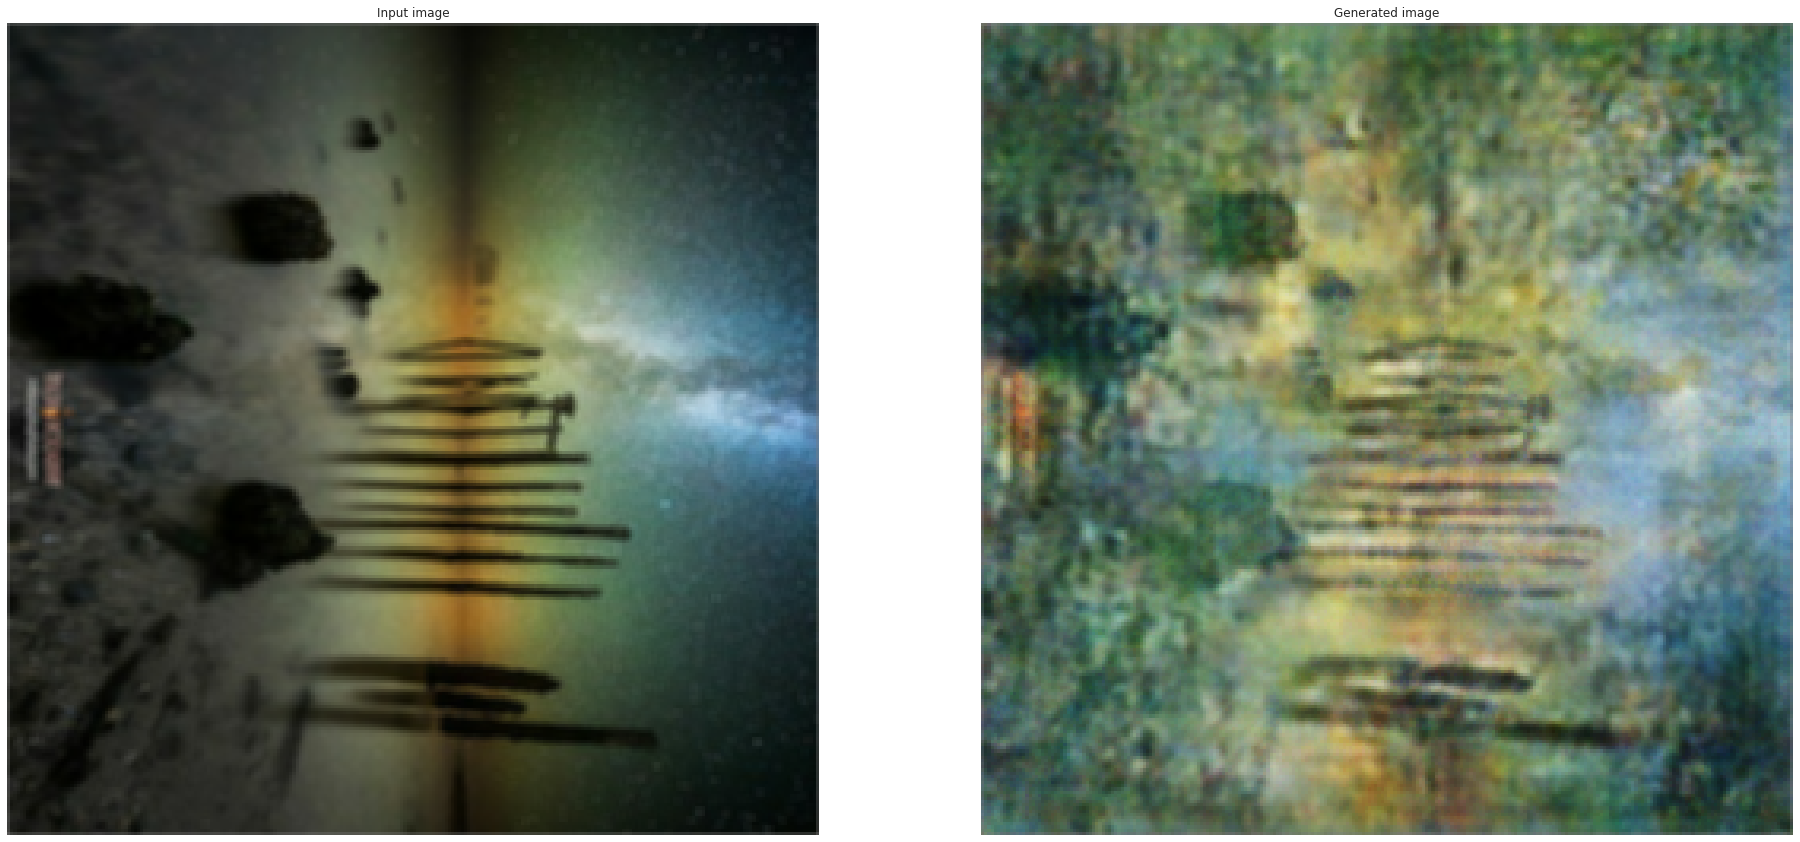

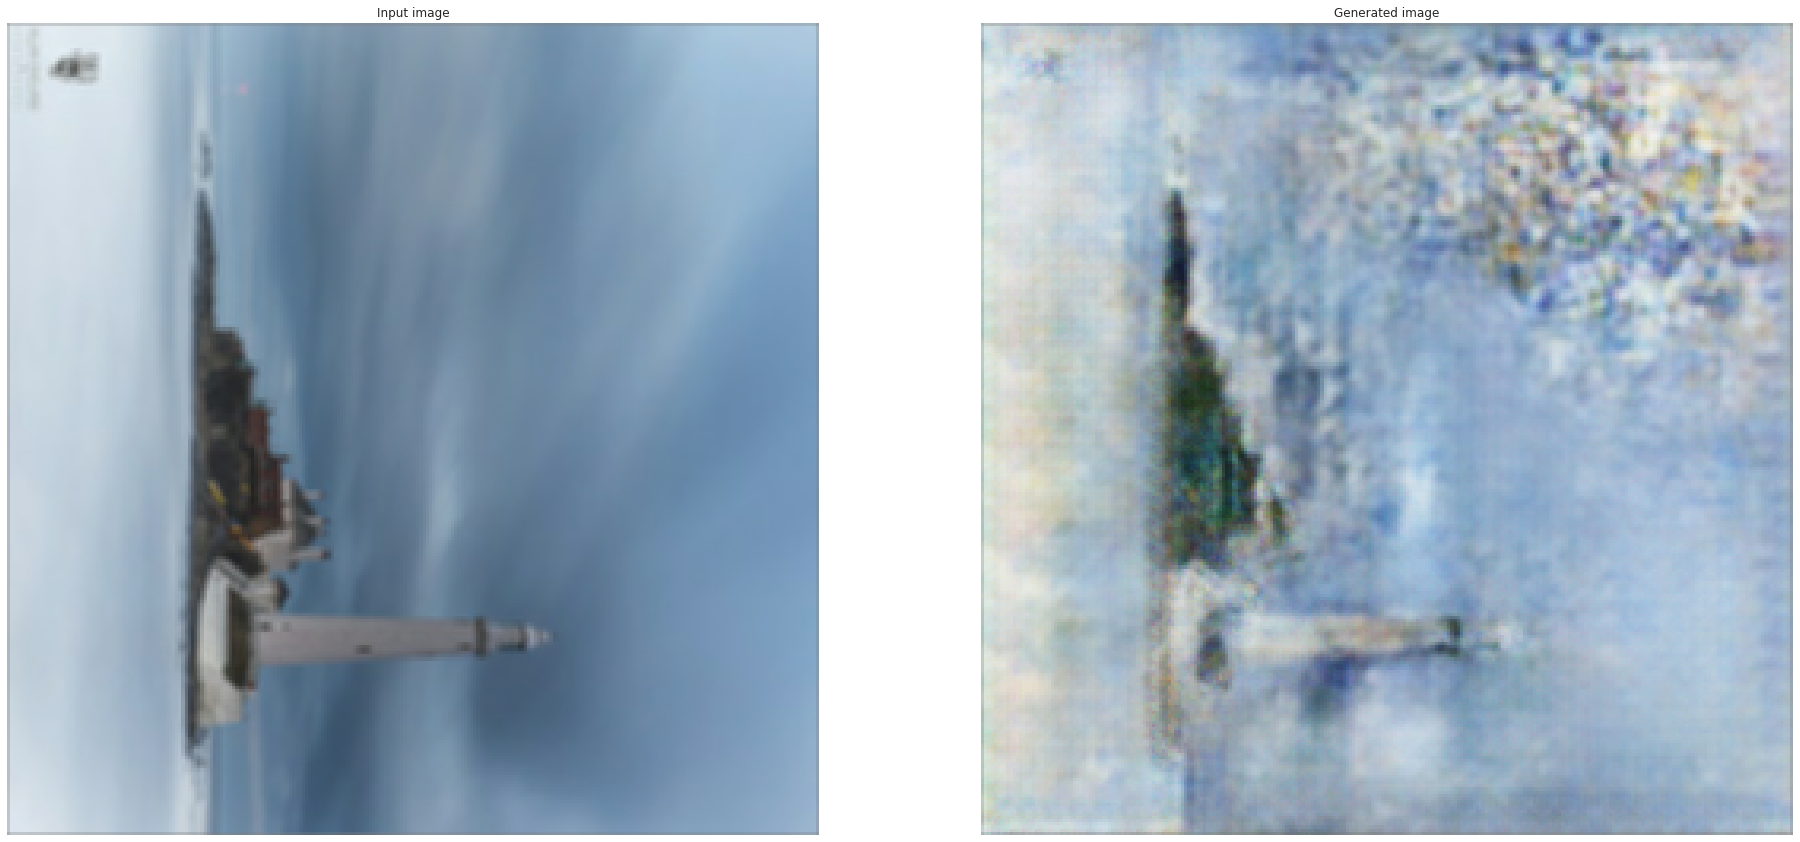

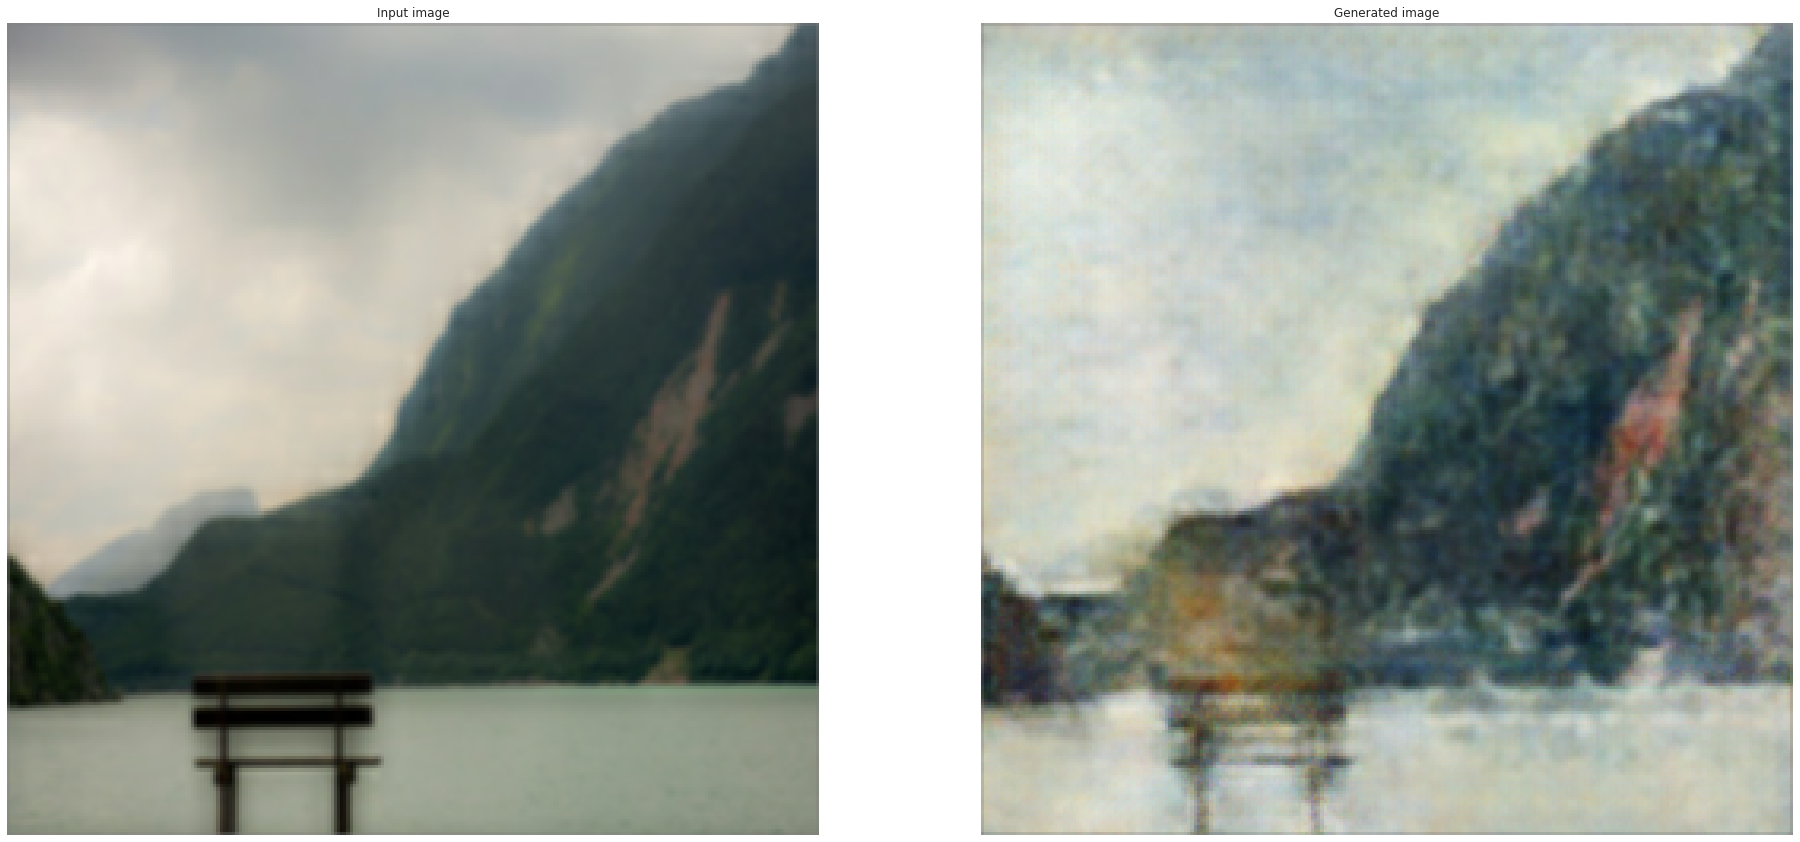

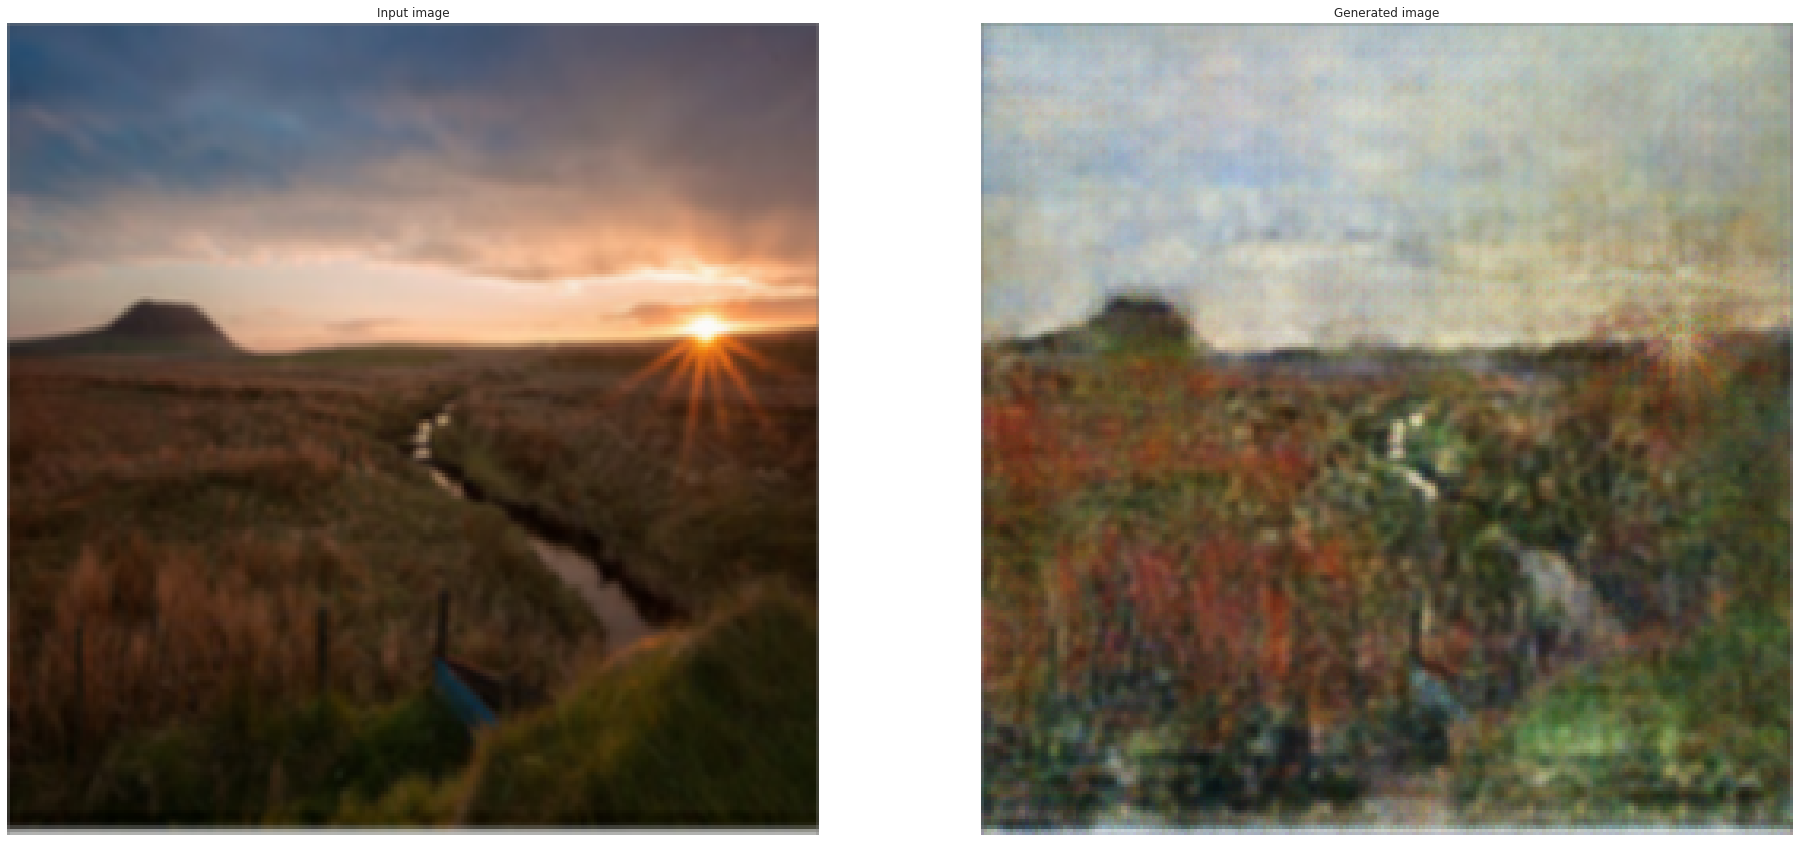

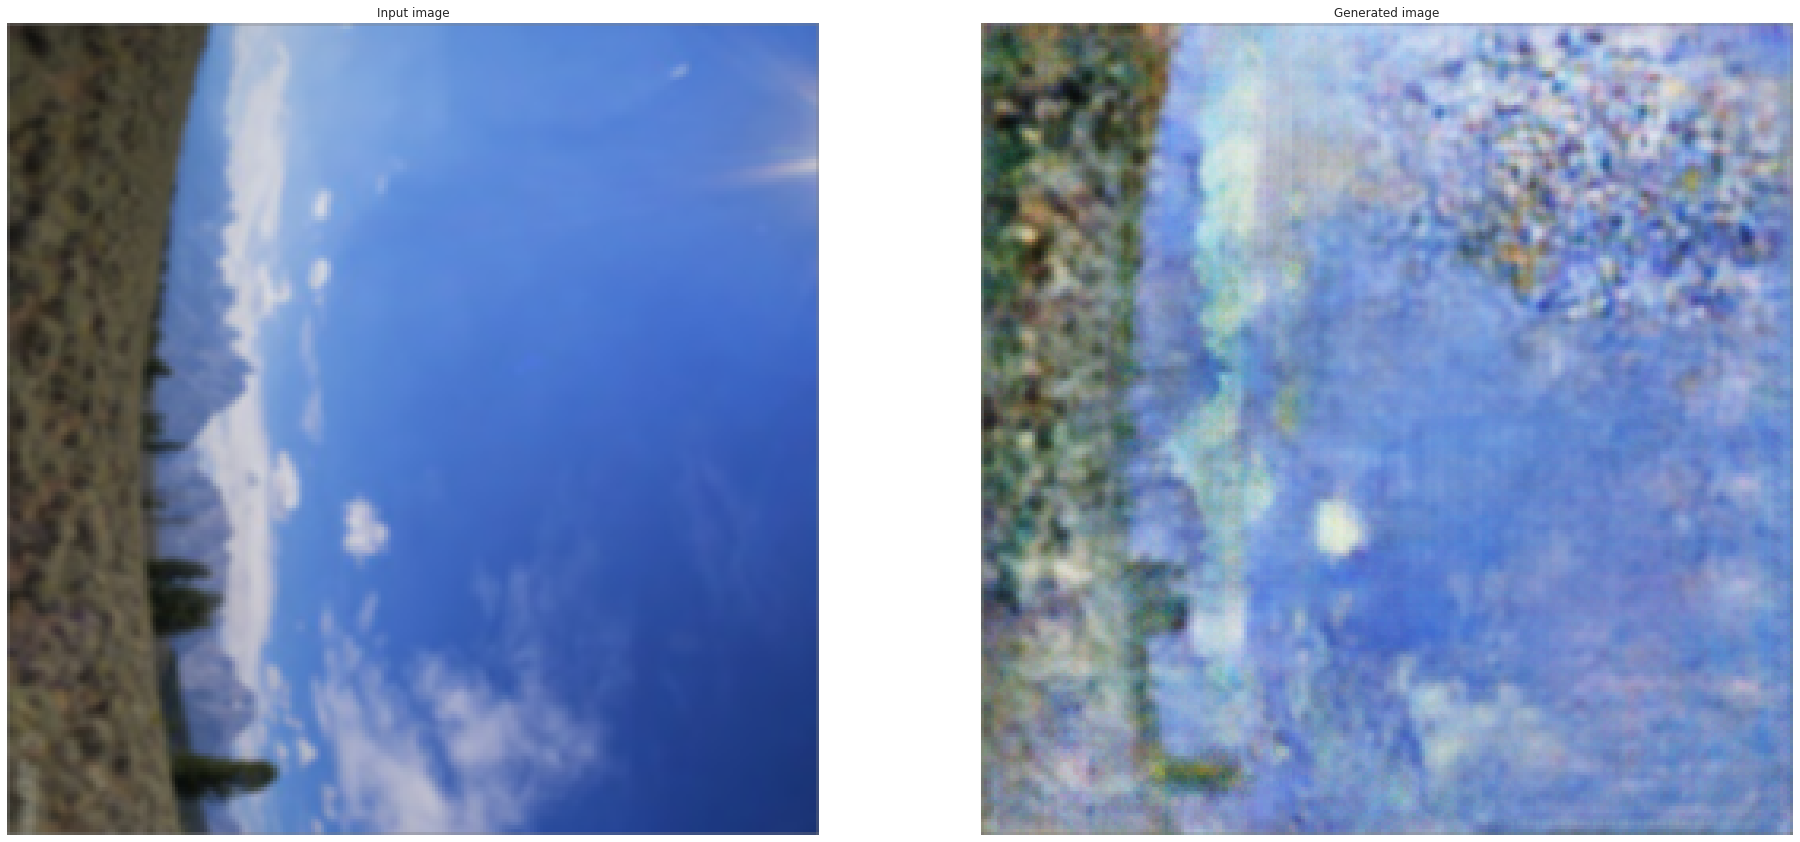

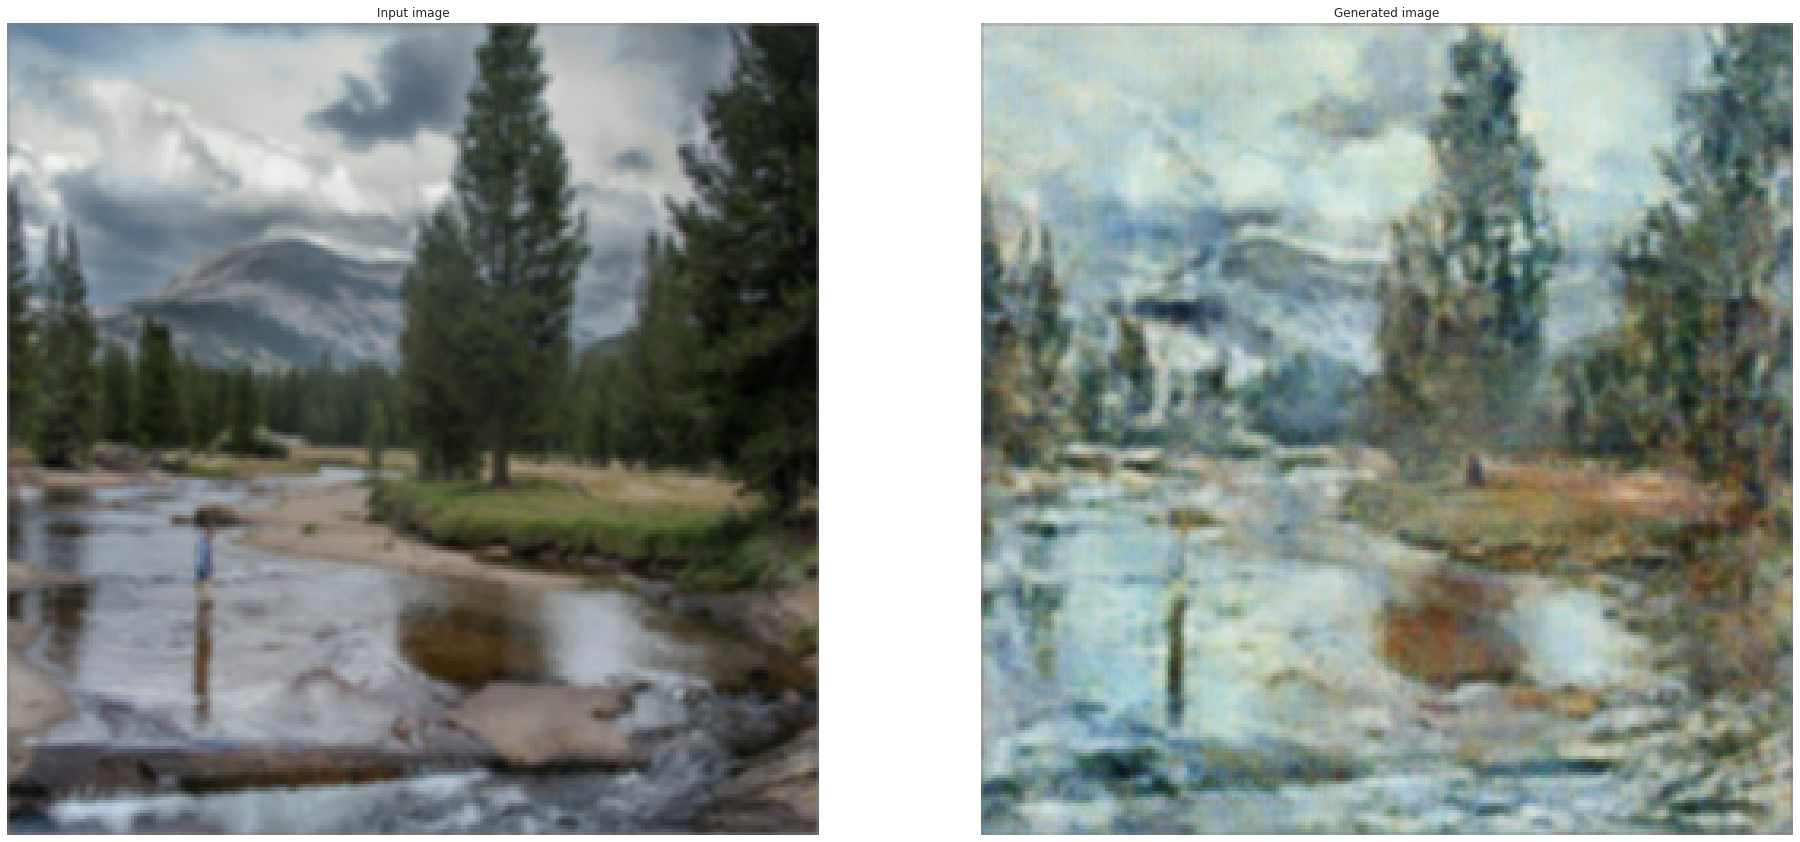

In [29]:
ds_iter = iter(photo_ds)
for n_sample in range(8):
        example_sample = next(ds_iter)
        generated_sample = monet_generator(example_sample)
        
        f = plt.figure(figsize=(32, 32))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

# Create submission file

In [30]:
import PIL
! mkdir ../images

In [31]:
i = 1

photo_ds = load_dataset(PHOTO_FILENAMES)
photo_ds = photo_ds.map(lambda p: photo_blur(p), num_parallel_calls=AUTOTUNE)
photo_ds = photo_ds.batch(1, drop_remainder=True)

for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [32]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'